In [1]:
import numpy as np
import pycbc.conversions as pc
import pycbc.pnutils as pnu
import pandas as pd
import h5py, os

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random

import sys
from lal import YRJUL_SI

import seaborn as sns

import ast

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
            
    return ans


def print_some_rcParams():
    rc_keys = ['backend', 'axes.labelsize', 'axes.titlesize', 'font.size',
        'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize', 'font.family',
        'text.usetex', 'figure.figsize'] # 'font.sans-serif', 'font.serif'
    print('Using the following matplotlib settings:')
    for k in rc_keys:
        print(k, ':', plt.rcParams[k])

In [3]:
ifar_threshold = 10 ## yr 
number_injection = 10

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [5]:
#This is the first file, all events are true
injection_file = '/home/bhooshan.gadre/work/O3/sub_solar_search/O3B_VTs/ssm-search/O3b_VTs/common_ssm_injections.hdf'
injections = load_dict_from_hdf5(injection_file)
injections.keys(), len(injections.keys())

(dict_keys(['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mass1_source', 'mass2_source', 'mbta_ifar', 'polarization', 'pycbc_ifar', 'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'time']),
 22)

In [6]:
df_true = pd.DataFrame(injections)
df_true

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09


In [7]:
#esto lo tengo que borrar, va a ser mi modelo de juguete
#df_true = df_true.sample(n=number_injection, random_state=42)
#df_true

In [8]:
#df_true = df_true[df_true['pycbc_ifar'] > ifar_threshold]
#df_true

In [9]:
df_true = df_true.drop(columns=['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mbta_ifar', 'polarization', 
                                'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin2x', 'spin2y', 'time'])

df_true['label'] = 1

df_true = df_true.rename(columns={'mass2_source': 'mass2', 
                                  'mass1_source': 'mass1'})

df_true

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
0,1.692460,0.501600,0.0,-0.037187,0.007150,1
1,6.421466,0.763863,0.0,0.021298,0.038439,1
2,10.481894,1.045793,0.0,0.012784,-0.030501,1
3,8.906005,0.811978,0.0,-0.000504,-0.004068,1
4,7.129897,0.808812,0.0,-0.001127,-0.003302,1
...,...,...,...,...,...,...
1916578,5.784159,0.559250,0.0,-0.038265,-0.032295,1
1916579,8.621294,0.868851,0.0,0.032837,-0.010397,1
1916580,10.560706,0.717379,0.0,-0.029833,-0.031378,1
1916581,5.727628,0.886952,0.0,-0.024699,0.007844,1


In [10]:
#this the background
trig_file = "/home/pycbc.offline/O3/production/O3A_SUB_SOLAR/sub_solar/STATMAP/H1L1V1-COMBINE_STATMAP_FULL_DATA-1238787802-853441.hdf"
bank_file = "/home/pycbc.offline/O3/production/O3A_SUB_SOLAR/sub_solar/BANK/H1L1V1-BANK2HDF-1238787802-853441.hdf"

In [11]:
%%time
bank = h5py.File(bank_file, 'r')
hashes = bank['template_hash'][:]

bank_tids = hashes.argsort()
fields = ['mass1', 'mass2', 'spin1z', 'spin2z']
trigs = h5py.File(trig_file, 'r')

trig_params = defaultdict(list)
for tid in trigs['background']['template_id'][:number_injection]:  ## test with 10 triggers. Later this can be [:] for all triggers
    bank_idx = np.argwhere(bank_tids == tid)[0]
    for k in fields:
        trig_params[k].append(bank[k][:][bank_idx][0])
#print(trig_params)

CPU times: user 525 ms, sys: 293 ms, total: 818 ms
Wall time: 1.69 s


In [12]:
print(trig_params)

defaultdict(<class 'list'>, {'mass1': [0.5049287468690198, 1.4890962096222466, 0.5584945606105989, 0.30992199092256534, 0.20621452536587256, 6.0120204674999655, 0.9745523320171033, 0.5214335060019926, 0.5423446824343688, 1.0842931303911676], 'mass2': [0.21458005221417903, 0.21205771715862032, 0.2044448030937099, 0.2008728164584661, 0.20621452536587256, 0.7340735619694843, 0.2556743567108287, 0.20865151534506626, 0.20605241989917558, 0.27170560413115535], 'spin1z': [-0.6862350742339347, -0.7286678705958807, 0.7745876481316094, -0.09982390851178215, 0.09989187095218796, 0.8999412988935003, 0.4513576754964428, 0.6390865474789664, -0.7355112205159183, -0.5541470127492194], 'spin2z': [-0.056092396754344645, 0.024225545145718428, 0.006712229612723681, -0.07828719811217069, 0.09990277072233664, 0.41893731416659385, -0.08913105732121088, 0.08529964032606609, 0.010133644484569012, 0.022674100783847937]})


In [13]:
len(trigs['background']['template_id'])

39955275

In [14]:
len(trigs['background_h0']['H1L1']['ifar'])

16322600

In [15]:
len(trigs['background_h0']['H1L1V1']['ifar'][:])

127274

In [16]:
trigs['background_h0']['H1L1V1']['ifar'][:10]

array([1.83540772, 0.02920396, 4.81109905, 0.03547405, 0.07905803,
       2.01532598, 0.00685824, 0.51929064, 0.03567827, 0.38252941])

In [17]:
background_file = '/home/lucashernan.quiceno/background/output.txt'

with open(background_file, 'r') as file:
    content = file.read()

# Convert the contents of the file into a Python dictionary
data_dict = ast.literal_eval(content.replace("defaultdict(<class 'list'>, ", "").rstrip(')'))

# Convert the dictionary to a DataFrame
df_false = pd.DataFrame(data_dict)

df_false

,mass1,mass2,spin1z,spin2z
0,0.504929,0.214580,-0.686235,-0.056092
1,1.489096,0.212058,-0.728668,0.024226
2,0.558495,0.204445,0.774588,0.006712
3,0.309922,0.200873,-0.099824,-0.078287
4,0.206215,0.206215,0.099892,0.099903
...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385
1916579,0.501223,0.202115,-0.743296,-0.011618
1916580,0.956881,0.213006,-0.813010,0.049815
1916581,0.808391,0.312963,-0.449955,-0.030445


In [18]:
#df_false = pd.DataFrame(trig_params)

df_false['pycbc_ifar'] = trigs['background_h0']['H1L1']['ifar'][:1916583]

df_false['label'] = 0
df_false

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
0,0.504929,0.214580,-0.686235,-0.056092,0.000314,0
1,1.489096,0.212058,-0.728668,0.024226,0.000070,0
2,0.558495,0.204445,0.774588,0.006712,0.000018,0
3,0.309922,0.200873,-0.099824,-0.078287,0.000821,0
4,0.206215,0.206215,0.099892,0.099903,0.000288,0
...,...,...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385,0.000010,0
1916579,0.501223,0.202115,-0.743296,-0.011618,0.000011,0
1916580,0.956881,0.213006,-0.813010,0.049815,0.000470,0
1916581,0.808391,0.312963,-0.449955,-0.030445,0.000045,0


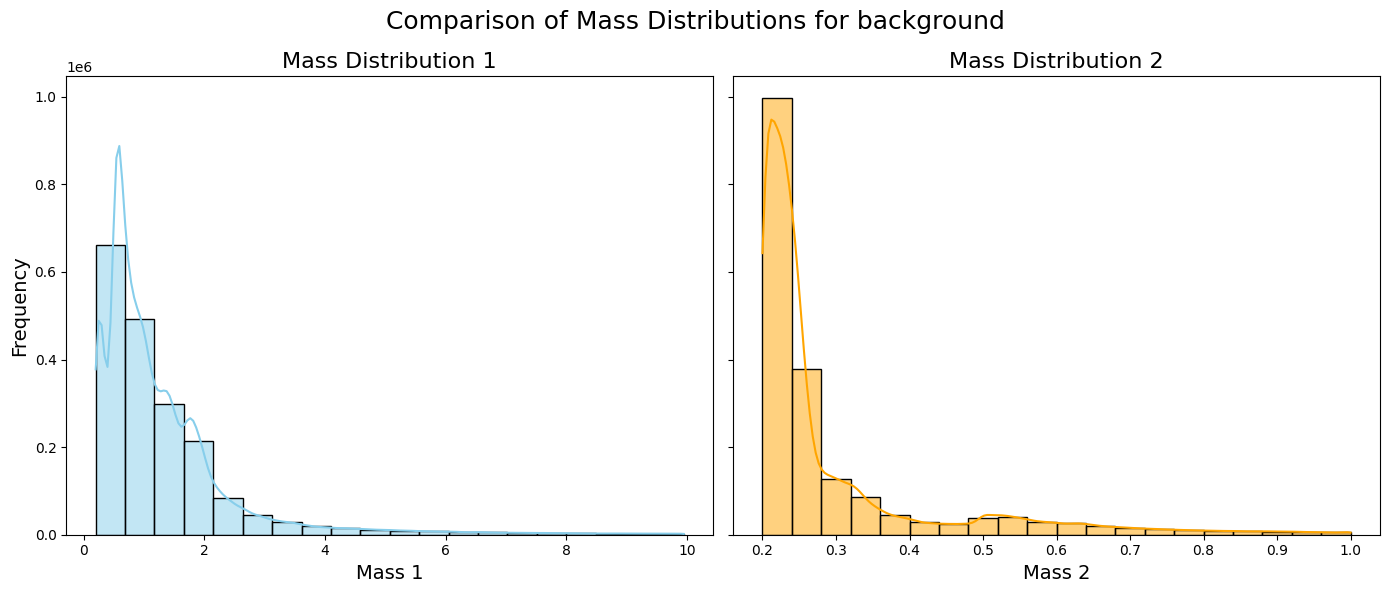

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'mass1'
sns.histplot(df_false['mass1'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('Mass 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Mass Distribution 1', fontsize=16)

# Plot of the distribution of 'mass2'
sns.histplot(df_false['mass2'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('Mass 2', fontsize=14)
axs[1].set_title('Mass Distribution 2', fontsize=16)

fig.suptitle('Comparison of Mass Distributions for background', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

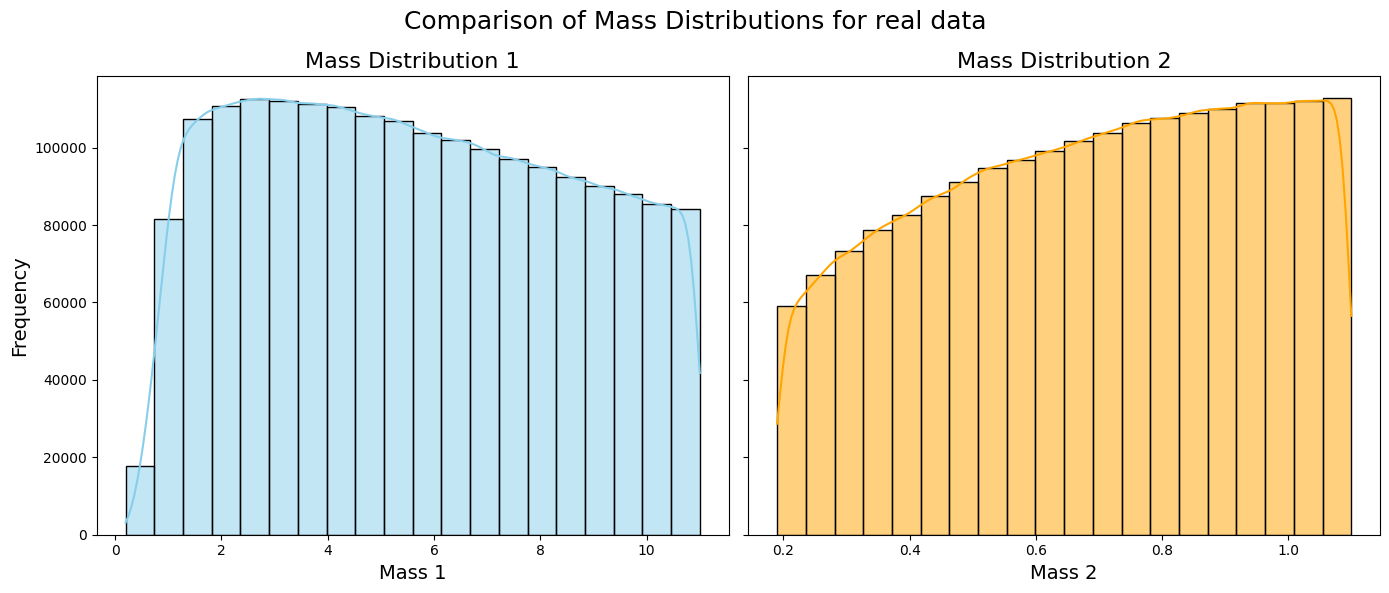

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'mass1'
sns.histplot(df_true['mass1'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('Mass 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Mass Distribution 1', fontsize=16)

# Plot of the distribution of 'mass2'
sns.histplot(df_true['mass2'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('Mass 2', fontsize=14)
axs[1].set_title('Mass Distribution 2', fontsize=16)

fig.suptitle('Comparison of Mass Distributions for real data', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

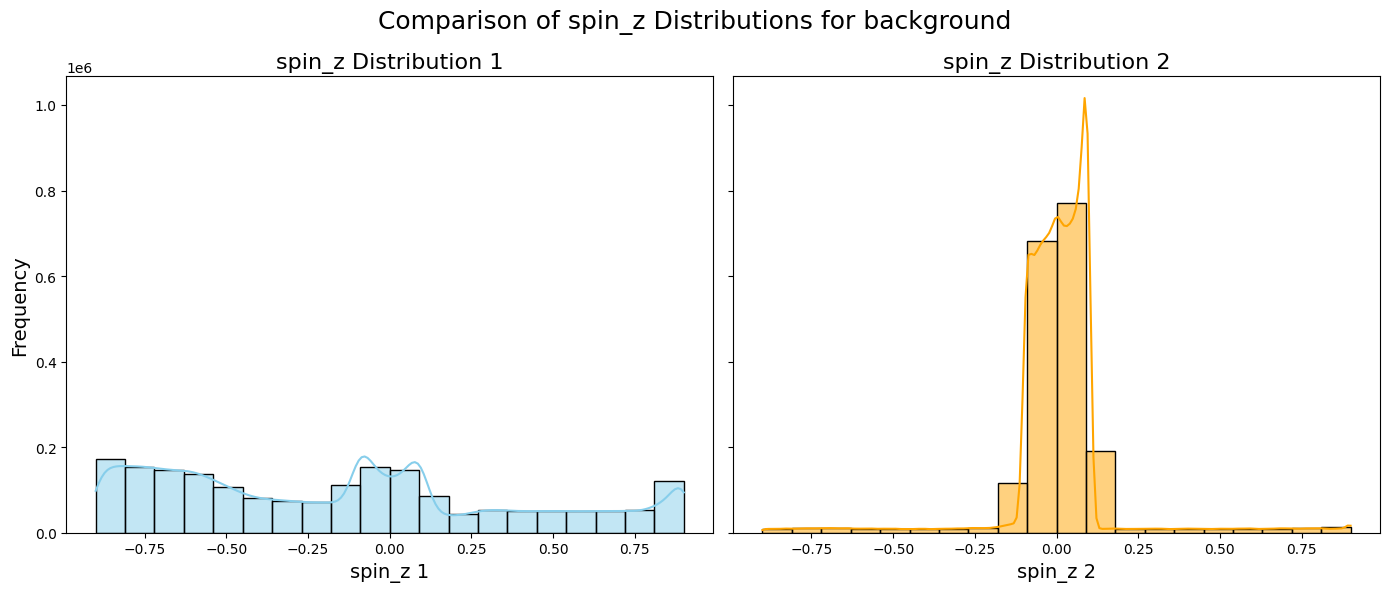

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'spin1z'
sns.histplot(df_false['spin1z'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('spin_z 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('spin_z Distribution 1', fontsize=16)

# Plot of the distribution of 'spin2z'
sns.histplot(df_false['spin2z'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('spin_z 2', fontsize=14)
axs[1].set_title('spin_z Distribution 2', fontsize=16)

fig.suptitle('Comparison of spin_z Distributions for background', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

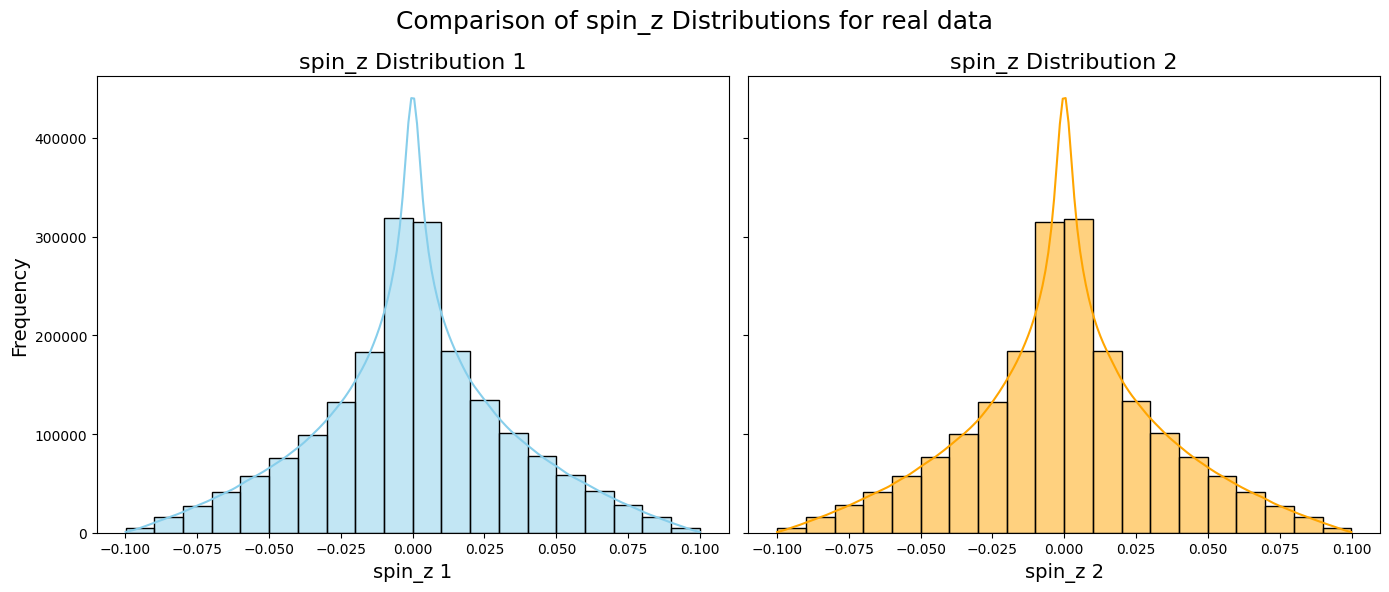

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'spin1z'
sns.histplot(df_true['spin1z'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('spin_z 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('spin_z Distribution 1', fontsize=16)

# Plot of the distribution of 'mass2'
sns.histplot(df_true['spin2z'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('spin_z 2', fontsize=14)
axs[1].set_title('spin_z Distribution 2', fontsize=16)

fig.suptitle('Comparison of spin_z Distributions for real data', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

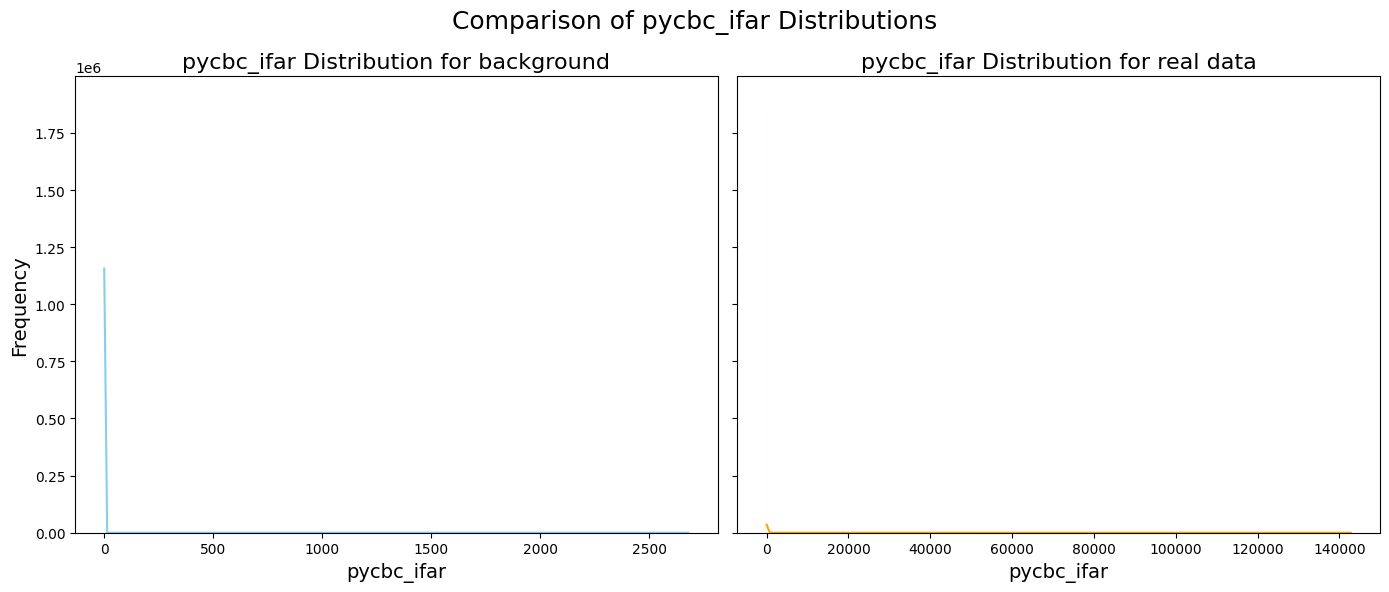

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'pycbc_ifar'
sns.histplot(df_false['pycbc_ifar'], bins=10000, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('pycbc_ifar', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('pycbc_ifar Distribution for background', fontsize=16)

# Plot of the distribution of 'spin2z'
sns.histplot(df_true['pycbc_ifar'], bins=10000, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('pycbc_ifar', fontsize=14)
axs[1].set_title('pycbc_ifar Distribution for real data', fontsize=16)

fig.suptitle('Comparison of pycbc_ifar Distributions', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

In [24]:
columns_greater_than_10 = (df_false['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_false' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_false' greater than 10: 358


In [25]:
columns_greater_than_10 = (df_true['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_true' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_true' greater than 10: 63312


In [26]:
df = pd.concat([df_true, df_false], axis=0)
df

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
0,1.692460,0.501600,0.000000,-0.037187,0.007150,1
1,6.421466,0.763863,0.000000,0.021298,0.038439,1
2,10.481894,1.045793,0.000000,0.012784,-0.030501,1
3,8.906005,0.811978,0.000000,-0.000504,-0.004068,1
4,7.129897,0.808812,0.000000,-0.001127,-0.003302,1
...,...,...,...,...,...,...
1916578,0.864843,0.247605,0.000010,-0.416889,0.025385,0
1916579,0.501223,0.202115,0.000011,-0.743296,-0.011618,0
1916580,0.956881,0.213006,0.000470,-0.813010,0.049815,0
1916581,0.808391,0.312963,0.000045,-0.449955,-0.030445,0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [28]:
# Exploración de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3833166 entries, 0 to 1916582
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   mass1       float64
 1   mass2       float64
 2   pycbc_ifar  float64
 3   spin1z      float64
 4   spin2z      float64
 5   label       int64  
dtypes: float64(5), int64(1)
memory usage: 204.7 MB


In [29]:
df.describe()

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
count,3.833166e+06,3.833166e+06,3.833166e+06,3.833166e+06,3.833166e+06,3833166.0
mean,3.471293e+00,4.917871e-01,3.175995e+02,-7.708433e-02,3.945316e-03,0.5
std,3.106359e+00,2.840450e-01,3.890053e+03,3.816217e-01,1.290550e-01,0.5
min,1.958331e-01,1.900007e-01,0.000000e+00,-9.000000e-01,-8.999972e-01,0.0
25%,9.126695e-01,2.351717e-01,0.000000e+00,-1.657461e-01,-3.013016e-02,0.0
50%,2.096459e+00,3.842256e-01,1.548821e-06,-6.712440e-03,1.399800e-03,0.5
75%,5.674761e+00,7.272952e-01,4.354362e-05,3.252966e-02,3.906670e-02,1.0
max,1.099997e+01,1.100000e+00,1.427988e+05,9.000000e-01,8.999999e-01,1.0


In [30]:
# Definir las características (features) y el objetivo (label)
X = df.drop('label', axis=1)
y = df['label']

In [31]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train

,mass1,mass2,pycbc_ifar,spin1z,spin2z
457198,1.913760,0.273239,0.000336,-0.034828,-0.011404
1504983,1.259362,0.270832,0.008402,0.631286,0.043176
1181923,4.821619,0.356829,0.000000,0.000097,0.001230
114185,1.273954,0.211858,0.000321,-0.737009,0.082421
191126,3.466504,0.873059,0.000000,0.006168,-0.019289
...,...,...,...,...,...
439747,1.258650,0.494431,0.000007,-0.898765,-0.099318
1594983,1.465865,0.230938,0.000012,-0.627842,0.012932
312501,0.947898,0.248354,0.000067,-0.394066,-0.004968
851724,0.205109,0.205109,0.000288,0.050495,-0.061751


In [33]:
#datos entrenamiento (deben ser 80%)
len(y_train)

3066532

In [34]:
y_train.value_counts()[0]

1533426

In [35]:
y_train.value_counts()[1]

1533106

In [36]:
#datos validación (deben ser 20%)
len(y_test)

766634

In [37]:
y_test.value_counts()[1]

383477

In [38]:
def evaluate_models(X, y):
    '''Esta función calcula el clasificador usando los tres modelos, Logistic Regression, Random Forest y Neural Network'''
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar los datos
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Definir los modelos a evaluar
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "Neural Network": MLPClassifier(max_iter=500)  # Asegúrate de establecer un número suficiente de iteraciones
    }

    results = {}

    for model_name, model in models.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir sobre el conjunto de prueba
        y_pred = model.predict(X_test)
        
        # Calcular métricas de rendimiento
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calcular el porcentaje de verdaderos positivos
        total_test_samples = len(y_test)
        tp_percentage_over_test = (tp / total_test_samples) * 100
        tp_percentage_over_test_positive = (tp / y_test.value_counts()[1]) * 100
        
        # Almacenar resultados en el diccionario
        results[model_name] = {
            'model': model,
            'roc_auc': roc_auc,
            'accuracy': accuracy,
            'report': classification_report(y_test, y_pred, output_dict=True),
            'confusion_matrix': {
                'true_negatives': tn,
                'false_positives': fp,
                'false_negatives': fn,
                'true_positives': tp
            },
            'tp_percentage_over_test': tp_percentage_over_test,
            'tp_percentage_over_test_positive': tp_percentage_over_test_positive
        }
        
        # Imprimir los resultados
        print(f"Results for {model_name}:")
        print(classification_report(y_test, y_pred))
        print(f"Confusion Matrix for {model_name}:")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
        print(f"Number of True Positives in y_test: {y_test.value_counts()[1]}")
        print(f"Percentage of True Positives over Test Set: {tp_percentage_over_test:.2f}%")
        print(f"Percentage of True Positives over Test Set Positives: {tp_percentage_over_test_positive:.2f}%")
        print(f"ROC-AUC Score: {roc_auc}")
        print(f"Accuracy: {accuracy}")
        print("\n")
        
        # Mostrar la Matriz de Confusión
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

    return results

In [39]:
def evaluate_logistic_regression(X, y):
    '''Esta función realiza todos los calculo pero solo para le Logistic Regression'''
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar los datos
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Crear y entrenar el modelo de Regresión Logística
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predecir sobre el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas de rendimiento
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calcular el porcentaje de verdaderos positivos
    total_test_samples = len(y_test)
    tp_percentage_over_test = (tp / total_test_samples) * 100
    tp_percentage_over_test_positive = (tp / y_test.value_counts()[1]) * 100

    # Almacenar resultados en el diccionario
    results = {
        'model': model,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': {
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp
        },
        'tp_percentage_over_test': tp_percentage_over_test,
        'tp_percentage_over_test_positive': tp_percentage_over_test_positive
    }

    # Imprimir los resultados
    print(f"Results for Logistic Regression:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for Logistic Regression:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Number of True Positives in y_test: {y_test.value_counts()[1]}")
    print(f"Percentage of True Positives over Test Set: {tp_percentage_over_test:.2f}%")
    print(f"Percentage of True Positives over Test Set Positives: {tp_percentage_over_test_positive:.2f}%")
    print(f"ROC-AUC Score: {roc_auc}")
    print(f"Accuracy: {accuracy}")
    print("\n")

    # Mostrar la Matriz de Confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix for Logistic Regression')
    plt.show()

    return results

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    383157
           1       0.92      0.89      0.91    383477

    accuracy                           0.91    766634
   macro avg       0.91      0.91      0.91    766634
weighted avg       0.91      0.91      0.91    766634

Confusion Matrix for Logistic Regression:
True Negatives: 352980
False Positives: 30177
False Negatives: 41511
True Positives: 341966
Number of True Positives in y_test: 383477
Percentage of True Positives over Test Set: 44.61%
Percentage of True Positives over Test Set Positives: 89.18%
ROC-AUC Score: 0.9064960834312312
Accuracy: 0.9064899287013098




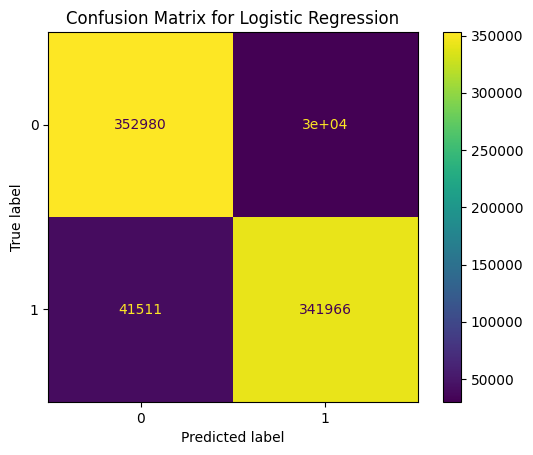

{'model': LogisticRegression(),
 'roc_auc': 0.9064960834312312,
 'accuracy': 0.9064899287013098,
 'report': {'0': {'precision': 0.8947732647893107,
   'recall': 0.9212411622389778,
   'f1-score': 0.9078143324486143,
   'support': 383157.0},
  '1': {'precision': 0.9189102038732423,
   'recall': 0.8917510046234846,
   'f1-score': 0.9051269156454302,
   'support': 383477.0},
  'accuracy': 0.9064899287013098,
  'macro avg': {'precision': 0.9068417343312765,
   'recall': 0.9064960834312312,
   'f1-score': 0.9064706240470223,
   'support': 766634.0},
  'weighted avg': {'precision': 0.906846771820161,
   'recall': 0.9064899287013098,
   'f1-score': 0.9064700631709217,
   'support': 766634.0}},
 'confusion_matrix': {'true_negatives': 352980,
  'false_positives': 30177,
  'false_negatives': 41511,
  'true_positives': 341966},
 'tp_percentage_over_test': 44.60616147992393,
 'tp_percentage_over_test_positive': 89.17510046234845}

In [40]:
evaluate_logistic_regression(X, y)

In [41]:
#esto se demora mucho pero hay que hacerlo y comparar con los resultados anteriores del otro notebook 
#evaluate_models(X, y)

# Changing the dataset. Without ifar

In [42]:
# Definir las características (features) y el objetivo (label)
X = df.drop(['label', 'pycbc_ifar'], axis=1)
y = df['label']

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    383157
           1       0.92      0.89      0.90    383477

    accuracy                           0.91    766634
   macro avg       0.91      0.91      0.91    766634
weighted avg       0.91      0.91      0.91    766634

Confusion Matrix for Logistic Regression:
True Negatives: 352533
False Positives: 30624
False Negatives: 42092
True Positives: 341385
Number of True Positives in y_test: 383477
Percentage of True Positives over Test Set: 44.53%
Percentage of True Positives over Test Set Positives: 89.02%
ROC-AUC Score: 0.9051552294562168
Accuracy: 0.9051490020009548




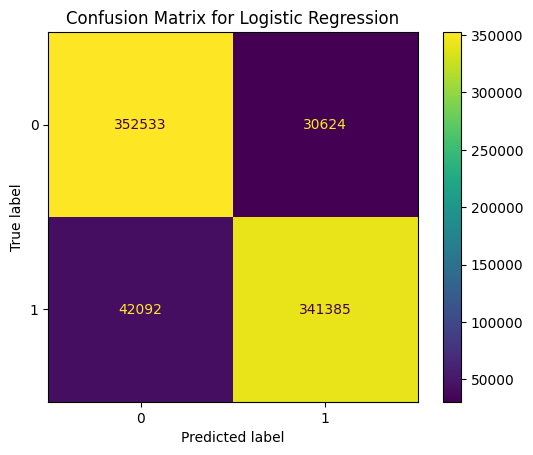

{'model': LogisticRegression(),
 'roc_auc': 0.9051552294562168,
 'accuracy': 0.9051490020009548,
 'report': {'0': {'precision': 0.8933367120684194,
   'recall': 0.9200745386355985,
   'f1-score': 0.9065085075252448,
   'support': 383157.0},
  '1': {'precision': 0.9176794109819923,
   'recall': 0.8902359202768354,
   'f1-score': 0.903749374574777,
   'support': 383477.0},
  'accuracy': 0.9051490020009548,
  'macro avg': {'precision': 0.9055080615252058,
   'recall': 0.905155229456217,
   'f1-score': 0.905128941050011,
   'support': 766634.0},
  'weighted avg': {'precision': 0.9055131419571019,
   'recall': 0.9051490020009548,
   'f1-score': 0.9051283652064245,
   'support': 766634.0}},
 'confusion_matrix': {'true_negatives': 352533,
  'false_positives': 30624,
  'false_negatives': 42092,
  'true_positives': 341385},
 'tp_percentage_over_test': 44.53037564209257,
 'tp_percentage_over_test_positive': 89.02359202768353}

In [43]:
evaluate_logistic_regression(X, y)

# Probability 

In [44]:
X

,mass1,mass2,spin1z,spin2z
0,1.692460,0.501600,-0.037187,0.007150
1,6.421466,0.763863,0.021298,0.038439
2,10.481894,1.045793,0.012784,-0.030501
3,8.906005,0.811978,-0.000504,-0.004068
4,7.129897,0.808812,-0.001127,-0.003302
...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385
1916579,0.501223,0.202115,-0.743296,-0.011618
1916580,0.956881,0.213006,-0.813010,0.049815
1916581,0.808391,0.312963,-0.449955,-0.030445


In [45]:
y

0          1
1          1
2          1
3          1
4          1
          ..
1916578    0
1916579    0
1916580    0
1916581    0
1916582    0
Name: label, Length: 3833166, dtype: int64

In [46]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
3833166 * 0.2

766633.2000000001

In [48]:
# Estandarizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
len(X_test)

766634

In [50]:
# Entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [51]:
# Predecir probabilidades en el conjunto de prueba
probabilidades = model.predict_proba(X_test)
len(probabilidades)

766634

In [52]:
# Mostrar las probabilidades para cada muestra en el conjunto de prueba
print(probabilidades)

[[0.02379465 0.97620535]
 [0.14659192 0.85340808]
 [0.00361436 0.99638564]
 ...
 [0.93622083 0.06377917]
 [0.34119646 0.65880354]
 [0.00461901 0.99538099]]


In [53]:
probabilidades[0,0], probabilidades[0,1]

(0.02379465302570638, 0.9762053469742936)

In [54]:
# Calcular la tasa de alarmas falsas (FAR)
# Suponiendo que la clase 1 es la positiva y 0 es la negativa

# Obtener predicciones
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# FAR = FP / (FP + TN)
FP = cm[0, 1]  # Falsos positivos
TN = cm[0, 0]  # Verdaderos negativos
FAR = FP / (FP + TN)

print(f"Tasa de alarmas falsas (FAR): {FAR:.4f}")


Tasa de alarmas falsas (FAR): 0.0799


In [55]:
cm

array([[352533,  30624],
       [ 42092, 341385]])

In [56]:
cm[0, 0], cm[0, 1]

(352533, 30624)

In [57]:
cm[1, 0], cm[1, 1] # Falsos negativos

(42092, 341385)

In [58]:
cm[1, 1]/y_test.value_counts()[1]

0.8902359202768354

# Cuts in the ifar

# ifar > 10

In [59]:
columns_greater_than_10 = (df_false['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_false' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_false' greater than 10: 358


In [60]:
columns_greater_than_10 = (df_true['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_true' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_true' greater than 10: 63312


In [61]:
df_false

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
0,0.504929,0.214580,-0.686235,-0.056092,0.000314,0
1,1.489096,0.212058,-0.728668,0.024226,0.000070,0
2,0.558495,0.204445,0.774588,0.006712,0.000018,0
3,0.309922,0.200873,-0.099824,-0.078287,0.000821,0
4,0.206215,0.206215,0.099892,0.099903,0.000288,0
...,...,...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385,0.000010,0
1916579,0.501223,0.202115,-0.743296,-0.011618,0.000011,0
1916580,0.956881,0.213006,-0.813010,0.049815,0.000470,0
1916581,0.808391,0.312963,-0.449955,-0.030445,0.000045,0


In [62]:
df_true

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
0,1.692460,0.501600,0.0,-0.037187,0.007150,1
1,6.421466,0.763863,0.0,0.021298,0.038439,1
2,10.481894,1.045793,0.0,0.012784,-0.030501,1
3,8.906005,0.811978,0.0,-0.000504,-0.004068,1
4,7.129897,0.808812,0.0,-0.001127,-0.003302,1
...,...,...,...,...,...,...
1916578,5.784159,0.559250,0.0,-0.038265,-0.032295,1
1916579,8.621294,0.868851,0.0,0.032837,-0.010397,1
1916580,10.560706,0.717379,0.0,-0.029833,-0.031378,1
1916581,5.727628,0.886952,0.0,-0.024699,0.007844,1


In [65]:
df_false_ifar_10 = df_false[df_false['pycbc_ifar'] > 10]
df_false_ifar_10

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
6239,1.129211,0.494514,-0.899860,-0.072271,10.197039,0
7751,0.547399,0.217088,0.441201,-0.037319,10.022269,0
8683,0.278654,0.224332,0.064740,0.078906,16.918181,0
11147,0.399051,0.200079,-0.099922,-0.099576,183.779780,0
14208,0.357954,0.201382,-0.097487,-0.097118,11.724922,0
...,...,...,...,...,...,...
1894031,1.393201,0.215449,-0.809985,0.041113,24.438800,0
1900545,0.724096,0.245961,0.733550,-0.012316,14.287633,0
1904515,0.211373,0.211373,0.096349,0.013501,111.671741,0
1906231,5.292538,0.577691,-0.679952,-0.791074,31.285468,0


In [66]:
df_false_ifar_10 = df_false_ifar_10.sample(n=358, random_state=42)
df_false_ifar_10

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
1220221,5.292538,0.577691,-0.679952,-0.791074,12.393627,0
181432,0.292173,0.200291,-0.099344,-0.099827,28.922178,0
1383804,0.221034,0.202902,-0.002072,0.077508,18.963126,0
1597635,2.511981,0.342997,-0.698789,0.070095,21.186733,0
255177,0.803819,0.250034,-0.210994,0.094907,26.147530,0
...,...,...,...,...,...,...
361193,0.964318,0.289867,-0.548212,-0.096577,15.780894,0
529599,0.964318,0.289867,-0.548212,-0.096577,18.951951,0
1444692,0.809229,0.251129,0.399672,0.022564,27.255476,0
1862119,1.917998,0.242400,-0.350473,0.089765,83.536263,0


In [63]:
df_true_ifar_10 = df_true[df_true['pycbc_ifar'] > 10]
df_true_ifar_10

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
17,10.044697,0.771064,10174.474264,0.003799,-0.034952,1
39,9.871082,0.608848,10174.474264,0.003390,0.002160,1
45,6.012620,0.290126,10174.474264,0.022516,0.025649,1
52,1.566219,0.522978,10174.474264,0.032162,-0.004396,1
59,5.331335,0.458099,10174.474264,-0.004934,0.009750,1
...,...,...,...,...,...,...
1903266,6.626040,0.982731,69.997932,-0.030900,-0.025199,1
1903269,10.661847,0.462810,25146.646963,0.011288,0.066585,1
1903305,2.810979,0.813847,54.111754,0.012777,-0.049325,1
1903359,8.898606,0.641294,25146.646963,-0.067872,-0.015317,1


In [64]:
df_true_ifar_10 = df_true_ifar_10.sample(n=358, random_state=42)
df_true_ifar_10

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
579272,0.985730,0.266588,44103.402498,0.050930,0.073739,1
1171285,9.219555,0.589602,10.928226,0.013219,-0.058871,1
1626141,9.049375,0.610746,40.673368,0.013440,-0.049692,1
1735998,9.901930,0.404715,303.516115,-0.010882,-0.031421,1
560600,3.944695,1.008438,96021.775686,-0.010776,0.022948,1
...,...,...,...,...,...,...
778503,6.154133,0.368706,3960.390381,-0.003065,0.009756,1
1040086,8.741722,0.795275,1115.034669,0.077630,-0.023038,1
910923,9.332078,0.449118,10468.750067,0.008273,0.002042,1
34621,4.918925,1.088015,10174.474264,0.037124,-0.017515,1


In [67]:
df_ifar_10 = pd.concat([df_true_ifar_10, df_false_ifar_10], axis=0)
df_ifar_10

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
579272,0.985730,0.266588,44103.402498,0.050930,0.073739,1
1171285,9.219555,0.589602,10.928226,0.013219,-0.058871,1
1626141,9.049375,0.610746,40.673368,0.013440,-0.049692,1
1735998,9.901930,0.404715,303.516115,-0.010882,-0.031421,1
560600,3.944695,1.008438,96021.775686,-0.010776,0.022948,1
...,...,...,...,...,...,...
361193,0.964318,0.289867,15.780894,-0.548212,-0.096577,0
529599,0.964318,0.289867,18.951951,-0.548212,-0.096577,0
1444692,0.809229,0.251129,27.255476,0.399672,0.022564,0
1862119,1.917998,0.242400,83.536263,-0.350473,0.089765,0


In [72]:
# Definir las características (features) y el objetivo (label)
X = df_ifar_10.drop('label', axis=1)
y = df_ifar_10['label']

In [73]:
X

,mass1,mass2,pycbc_ifar,spin1z,spin2z
579272,0.985730,0.266588,44103.402498,0.050930,0.073739
1171285,9.219555,0.589602,10.928226,0.013219,-0.058871
1626141,9.049375,0.610746,40.673368,0.013440,-0.049692
1735998,9.901930,0.404715,303.516115,-0.010882,-0.031421
560600,3.944695,1.008438,96021.775686,-0.010776,0.022948
...,...,...,...,...,...
361193,0.964318,0.289867,15.780894,-0.548212,-0.096577
529599,0.964318,0.289867,18.951951,-0.548212,-0.096577
1444692,0.809229,0.251129,27.255476,0.399672,0.022564
1862119,1.917998,0.242400,83.536263,-0.350473,0.089765


In [74]:
y

579272     1
1171285    1
1626141    1
1735998    1
560600     1
          ..
361193     0
529599     0
1444692    0
1862119    0
522271     0
Name: label, Length: 716, dtype: int64

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        66
           1       0.97      0.90      0.93        78

    accuracy                           0.93       144
   macro avg       0.93      0.93      0.93       144
weighted avg       0.93      0.93      0.93       144

Confusion Matrix for Logistic Regression:
True Negatives: 64
False Positives: 2
False Negatives: 8
True Positives: 70
Number of True Positives in y_test: 78
Percentage of True Positives over Test Set: 48.61%
Percentage of True Positives over Test Set Positives: 89.74%
ROC-AUC Score: 0.9335664335664335
Accuracy: 0.9305555555555556




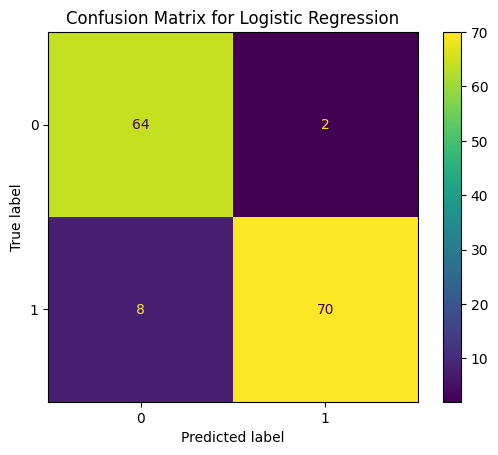

{'model': LogisticRegression(),
 'roc_auc': 0.9335664335664335,
 'accuracy': 0.9305555555555556,
 'report': {'0': {'precision': 0.8888888888888888,
   'recall': 0.9696969696969697,
   'f1-score': 0.927536231884058,
   'support': 66.0},
  '1': {'precision': 0.9722222222222222,
   'recall': 0.8974358974358975,
   'f1-score': 0.9333333333333333,
   'support': 78.0},
  'accuracy': 0.9305555555555556,
  'macro avg': {'precision': 0.9305555555555556,
   'recall': 0.9335664335664335,
   'f1-score': 0.9304347826086956,
   'support': 144.0},
  'weighted avg': {'precision': 0.9340277777777778,
   'recall': 0.9305555555555556,
   'f1-score': 0.9306763285024154,
   'support': 144.0}},
 'confusion_matrix': {'true_negatives': 64,
  'false_positives': 2,
  'false_negatives': 8,
  'true_positives': 70},
 'tp_percentage_over_test': 48.61111111111111,
 'tp_percentage_over_test_positive': 89.74358974358975}

In [75]:
evaluate_logistic_regression(X, y)

# ifar > 5

In [77]:
columns_greater_than_5 = (df_false['pycbc_ifar'] > 5).sum()
print(f"Number of columns in 'ifar_false' greater than 5: {columns_greater_than_5}")

Number of columns in 'ifar_false' greater than 5: 709


In [78]:
columns_greater_than_5 = (df_true['pycbc_ifar'] > 5).sum()
print(f"Number of columns in 'ifar_true' greater than 5: {columns_greater_than_5}")

Number of columns in 'ifar_true' greater than 5: 64990


In [79]:
df_false_ifar_5 = df_false[df_false['pycbc_ifar'] > 5]
df_false_ifar_5

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
2282,0.739640,0.206981,0.894864,-0.079506,5.634454,0
5463,3.393604,0.563449,0.797574,0.051339,8.010327,0
6239,1.129211,0.494514,-0.899860,-0.072271,10.197039,0
7751,0.547399,0.217088,0.441201,-0.037319,10.022269,0
7928,1.283438,0.225969,-0.101739,0.096776,5.680230,0
...,...,...,...,...,...,...
1909136,0.564133,0.209420,-0.755966,0.079123,5.208334,0
1912281,0.566681,0.228583,-0.530796,0.082045,7.475932,0
1912861,3.281388,0.586350,0.317070,-0.421900,5.950317,0
1914425,8.924599,0.968284,0.083194,-0.313758,7.915693,0


In [81]:
df_false_ifar_5 = df_false_ifar_5.sample(n=709, random_state=42)
df_false_ifar_5

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
789558,1.638293,0.233340,0.211086,0.065603,12.963104,0
672524,0.538894,0.202034,-0.729947,0.050454,7.087144,0
1640041,2.287654,0.275322,-0.787706,-0.041281,161.615384,0
951045,2.650655,0.266995,-0.866471,-0.036806,68.574545,0
627388,0.819659,0.246135,0.802408,0.099162,5.865669,0
...,...,...,...,...,...,...
158782,2.495179,0.592119,0.090045,0.313633,9.640726,0
251435,2.097593,0.212226,-0.865639,-0.087786,10.738384,0
718701,0.643357,0.211574,-0.865133,-0.090234,9.297907,0
1200177,0.628901,0.246309,0.125135,0.090471,10.530930,0


In [82]:
df_true_ifar_5 = df_true[df_true['pycbc_ifar'] > 5]
df_true_ifar_5

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
17,10.044697,0.771064,10174.474264,0.003799,-0.034952,1
39,9.871082,0.608848,10174.474264,0.003390,0.002160,1
45,6.012620,0.290126,10174.474264,0.022516,0.025649,1
52,1.566219,0.522978,10174.474264,0.032162,-0.004396,1
59,5.331335,0.458099,10174.474264,-0.004934,0.009750,1
...,...,...,...,...,...,...
1903266,6.626040,0.982731,69.997932,-0.030900,-0.025199,1
1903269,10.661847,0.462810,25146.646963,0.011288,0.066585,1
1903305,2.810979,0.813847,54.111754,0.012777,-0.049325,1
1903359,8.898606,0.641294,25146.646963,-0.067872,-0.015317,1


In [83]:
df_true_ifar_5 = df_true_ifar_5.sample(n=709, random_state=42)
df_true_ifar_5

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
753977,9.980819,0.953580,8403.817336,0.007687,-0.020364,1
1631551,2.871312,0.734667,3584.133908,-0.043850,-0.008440,1
200272,0.710897,0.312769,12831.152649,0.031341,-0.047189,1
639331,3.055378,0.888198,11139.751469,-0.005445,-0.003647,1
1313498,4.094557,1.033575,1107.474120,-0.088660,0.035172,1
...,...,...,...,...,...,...
842921,1.572502,0.374468,8030.908409,-0.077941,0.033000,1
1599374,8.557961,0.267809,10975.276802,0.030885,0.057905,1
1485353,2.580565,1.052848,35.553599,-0.006641,-0.073181,1
1694305,2.204716,0.894031,68510.496008,0.031403,-0.036930,1


In [84]:
df_ifar_5 = pd.concat([df_true_ifar_5, df_false_ifar_5], axis=0)
df_ifar_5

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
753977,9.980819,0.953580,8403.817336,0.007687,-0.020364,1
1631551,2.871312,0.734667,3584.133908,-0.043850,-0.008440,1
200272,0.710897,0.312769,12831.152649,0.031341,-0.047189,1
639331,3.055378,0.888198,11139.751469,-0.005445,-0.003647,1
1313498,4.094557,1.033575,1107.474120,-0.088660,0.035172,1
...,...,...,...,...,...,...
158782,2.495179,0.592119,9.640726,0.090045,0.313633,0
251435,2.097593,0.212226,10.738384,-0.865639,-0.087786,0
718701,0.643357,0.211574,9.297907,-0.865133,-0.090234,0
1200177,0.628901,0.246309,10.530930,0.125135,0.090471,0


In [85]:
# Definir las características (features) y el objetivo (label)
X = df_ifar_5.drop('label', axis=1)
y = df_ifar_5['label']

In [86]:
X

,mass1,mass2,pycbc_ifar,spin1z,spin2z
753977,9.980819,0.953580,8403.817336,0.007687,-0.020364
1631551,2.871312,0.734667,3584.133908,-0.043850,-0.008440
200272,0.710897,0.312769,12831.152649,0.031341,-0.047189
639331,3.055378,0.888198,11139.751469,-0.005445,-0.003647
1313498,4.094557,1.033575,1107.474120,-0.088660,0.035172
...,...,...,...,...,...
158782,2.495179,0.592119,9.640726,0.090045,0.313633
251435,2.097593,0.212226,10.738384,-0.865639,-0.087786
718701,0.643357,0.211574,9.297907,-0.865133,-0.090234
1200177,0.628901,0.246309,10.530930,0.125135,0.090471


In [87]:
y

753977     1
1631551    1
200272     1
639331     1
1313498    1
          ..
158782     0
251435     0
718701     0
1200177    0
230193     0
Name: label, Length: 1418, dtype: int64

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       142
           1       0.96      0.94      0.95       142

    accuracy                           0.95       284
   macro avg       0.95      0.95      0.95       284
weighted avg       0.95      0.95      0.95       284

Confusion Matrix for Logistic Regression:
True Negatives: 137
False Positives: 5
False Negatives: 9
True Positives: 133
Number of True Positives in y_test: 142
Percentage of True Positives over Test Set: 46.83%
Percentage of True Positives over Test Set Positives: 93.66%
ROC-AUC Score: 0.9507042253521126
Accuracy: 0.9507042253521126




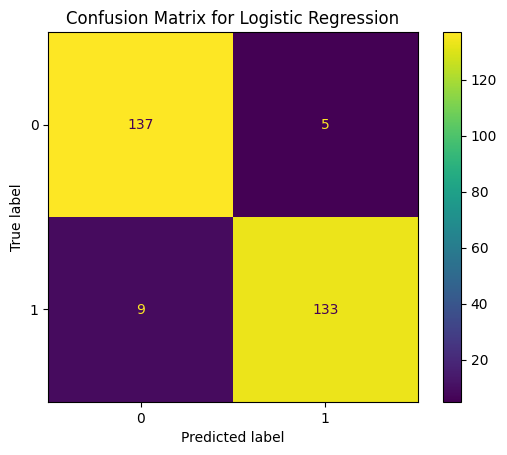

{'model': LogisticRegression(),
 'roc_auc': 0.9507042253521126,
 'accuracy': 0.9507042253521126,
 'report': {'0': {'precision': 0.9383561643835616,
   'recall': 0.9647887323943662,
   'f1-score': 0.9513888888888888,
   'support': 142.0},
  '1': {'precision': 0.9637681159420289,
   'recall': 0.9366197183098591,
   'f1-score': 0.95,
   'support': 142.0},
  'accuracy': 0.9507042253521126,
  'macro avg': {'precision': 0.9510621401627952,
   'recall': 0.9507042253521127,
   'f1-score': 0.9506944444444444,
   'support': 284.0},
  'weighted avg': {'precision': 0.9510621401627951,
   'recall': 0.9507042253521126,
   'f1-score': 0.9506944444444446,
   'support': 284.0}},
 'confusion_matrix': {'true_negatives': 137,
  'false_positives': 5,
  'false_negatives': 9,
  'true_positives': 133},
 'tp_percentage_over_test': 46.83098591549296,
 'tp_percentage_over_test_positive': 93.66197183098592}

In [88]:
evaluate_logistic_regression(X, y)

# ifar > 1

In [89]:
columns_greater_than_1 = (df_false['pycbc_ifar'] > 1).sum()
print(f"Number of columns in 'ifar_false' greater than 1: {columns_greater_than_1}")

Number of columns in 'ifar_false' greater than 1: 3672


In [90]:
columns_greater_than_1 = (df_true['pycbc_ifar'] > 1).sum()
print(f"Number of columns in 'ifar_true' greater than 1: {columns_greater_than_1}")

Number of columns in 'ifar_true' greater than 1: 69215


In [91]:
df_false_ifar_1 = df_false[df_false['pycbc_ifar'] > 1]
df_false_ifar_1

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
125,0.254007,0.205097,-0.077999,-0.070844,2.278047,0
489,0.693647,0.226404,-0.528040,-0.039054,2.954659,0
807,1.151842,0.264487,0.450500,0.061638,1.410281,0
1565,1.581936,0.304633,0.869345,0.083935,1.233516,0
2020,0.875801,0.253734,-0.159187,0.094701,1.365435,0
...,...,...,...,...,...,...
1913940,0.893330,0.462448,-0.370572,-0.048353,4.428124,0
1914425,8.924599,0.968284,0.083194,-0.313758,7.915693,0
1914521,0.216305,0.202742,-0.010368,-0.063788,17.857558,0
1914537,0.627833,0.213326,0.618484,-0.037051,1.326684,0


In [92]:
df_false_ifar_1 = df_false_ifar_1.sample(n=3672 , random_state=42)
df_false_ifar_1

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
1174274,0.618476,0.204562,0.873428,0.045513,1.764592,0
1411693,1.003811,0.248457,-0.362380,-0.031735,1.083425,0
864307,1.624606,0.245101,-0.554412,0.026597,45.107239,0
1084615,3.536838,0.417858,-0.835952,0.006658,1.022817,0
1713896,0.801503,0.224047,-0.539085,0.037707,1.342410,0
...,...,...,...,...,...,...
563410,2.653814,0.293232,0.870522,-0.032210,3.715082,0
664375,0.716365,0.205758,-0.858991,-0.091821,3.681486,0
419318,0.876796,0.303732,-0.577985,0.099242,13.383879,0
1840220,0.256535,0.208009,-0.072766,-0.092387,3.235885,0


In [93]:
df_true_ifar_1 = df_true[df_true['pycbc_ifar'] > 1]
df_true_ifar_1

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
17,10.044697,0.771064,10174.474264,0.003799,-0.034952,1
39,9.871082,0.608848,10174.474264,0.003390,0.002160,1
45,6.012620,0.290126,10174.474264,0.022516,0.025649,1
52,1.566219,0.522978,10174.474264,0.032162,-0.004396,1
59,5.331335,0.458099,10174.474264,-0.004934,0.009750,1
...,...,...,...,...,...,...
1903269,10.661847,0.462810,25146.646963,0.011288,0.066585,1
1903287,3.307214,0.662096,1.007866,0.051514,-0.023216,1
1903305,2.810979,0.813847,54.111754,0.012777,-0.049325,1
1903359,8.898606,0.641294,25146.646963,-0.067872,-0.015317,1


In [98]:
df_true_ifar_1 = df_true_ifar_1.sample(n=3672 , random_state=42)
df_true_ifar_1

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
848145,3.158454,0.790967,63310.161341,0.067427,0.004833,1
256465,3.138999,0.985071,44823.494464,0.063054,-0.022417,1
342655,4.288723,0.235948,11068.602356,0.021790,-0.045929,1
947654,7.239416,0.376471,475.926303,0.034017,0.002408,1
676266,6.864852,0.913120,11139.751469,-0.011771,0.059166,1
...,...,...,...,...,...,...
286249,10.962975,0.455064,52733.162277,0.006218,-0.012654,1
1745984,0.615709,0.200332,395.146556,-0.043646,0.004019,1
1081161,1.072607,0.332724,7074.437877,-0.002568,-0.001248,1
1606550,7.948319,0.699205,51567.652530,-0.081488,0.000127,1


In [99]:
df_ifar_1 = pd.concat([df_true_ifar_1, df_false_ifar_1], axis=0)
df_ifar_1

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
848145,3.158454,0.790967,63310.161341,0.067427,0.004833,1
256465,3.138999,0.985071,44823.494464,0.063054,-0.022417,1
342655,4.288723,0.235948,11068.602356,0.021790,-0.045929,1
947654,7.239416,0.376471,475.926303,0.034017,0.002408,1
676266,6.864852,0.913120,11139.751469,-0.011771,0.059166,1
...,...,...,...,...,...,...
563410,2.653814,0.293232,3.715082,0.870522,-0.032210,0
664375,0.716365,0.205758,3.681486,-0.858991,-0.091821,0
419318,0.876796,0.303732,13.383879,-0.577985,0.099242,0
1840220,0.256535,0.208009,3.235885,-0.072766,-0.092387,0


In [103]:
# Definir las características (features) y el objetivo (label)
X = df_ifar_1.drop('label', axis=1)
y = df_ifar_1['label']

In [104]:
X

,mass1,mass2,pycbc_ifar,spin1z,spin2z
848145,3.158454,0.790967,63310.161341,0.067427,0.004833
256465,3.138999,0.985071,44823.494464,0.063054,-0.022417
342655,4.288723,0.235948,11068.602356,0.021790,-0.045929
947654,7.239416,0.376471,475.926303,0.034017,0.002408
676266,6.864852,0.913120,11139.751469,-0.011771,0.059166
...,...,...,...,...,...
563410,2.653814,0.293232,3.715082,0.870522,-0.032210
664375,0.716365,0.205758,3.681486,-0.858991,-0.091821
419318,0.876796,0.303732,13.383879,-0.577985,0.099242
1840220,0.256535,0.208009,3.235885,-0.072766,-0.092387


In [105]:
y

848145     1
256465     1
342655     1
947654     1
676266     1
          ..
563410     0
664375     0
419318     0
1840220    0
1658035    0
Name: label, Length: 7344, dtype: int64

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       715
           1       0.97      0.94      0.96       754

    accuracy                           0.96      1469
   macro avg       0.96      0.96      0.96      1469
weighted avg       0.96      0.96      0.96      1469

Confusion Matrix for Logistic Regression:
True Negatives: 692
False Positives: 23
False Negatives: 42
True Positives: 712
Number of True Positives in y_test: 754
Percentage of True Positives over Test Set: 48.47%
Percentage of True Positives over Test Set Positives: 94.43%
ROC-AUC Score: 0.9560646250301423
Accuracy: 0.9557522123893806




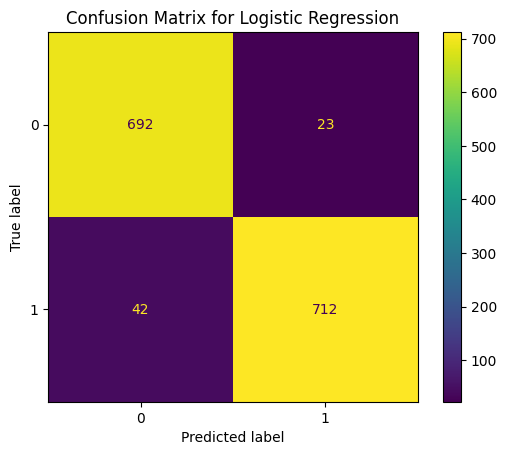

{'model': LogisticRegression(),
 'roc_auc': 0.9560646250301423,
 'accuracy': 0.9557522123893806,
 'report': {'0': {'precision': 0.9427792915531336,
   'recall': 0.9678321678321679,
   'f1-score': 0.9551414768806074,
   'support': 715.0},
  '1': {'precision': 0.9687074829931973,
   'recall': 0.9442970822281167,
   'f1-score': 0.9563465413028879,
   'support': 754.0},
  'accuracy': 0.9557522123893806,
  'macro avg': {'precision': 0.9557433872731654,
   'recall': 0.9560646250301423,
   'f1-score': 0.9557440090917476,
   'support': 1469.0},
  'weighted avg': {'precision': 0.9560875668055556,
   'recall': 0.9557522123893806,
   'f1-score': 0.9557600055221319,
   'support': 1469.0}},
 'confusion_matrix': {'true_negatives': 692,
  'false_positives': 23,
  'false_negatives': 42,
  'true_positives': 712},
 'tp_percentage_over_test': 48.46834581347856,
 'tp_percentage_over_test_positive': 94.42970822281167}

In [106]:
evaluate_logistic_regression(X, y)